<a href="https://colab.research.google.com/github/cfms-lab/SignedShadowCasting2021/blob/main/tomoNV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified Support Structure Tomography for optimal 3D printing

**Minimization of polymer filament usage in fused deposition modeling type 3D printing using modified support structure tomography**



by JY Jeong , S Chee, I. Sul of CFMS laboratory @ Kumon National Institute of Technology, Republic of Korea (2022)  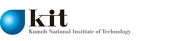

- First, you need to upload mesh file in google drive (the folder-like icon at the left hand side of this window), and wrie the file name in the section #2. 
- Install "Open3D" package once, everytime you visit this page (Google Colab pages are refreshed every 12 hours).
- Input g-code generation options in the "parameters" of section #3 ,
- This file is for demonstrational purpose only. It can have small errors because some features of Mathematica source code were omitted for the brevity's sake (All the coordinates were regarded as integers. Weighted-sum function for Mss was not applied. Noise points were suppressed within the object bounding volume.)


# #1. Install Open3D package 
 (You need to execute this cell only once. This cell does not have any output)

In [ ]:
!pip install open3d

# #1. Constants and sub-routines. 
 (You need to execute this cell only once. This cell does not have any output)

In [ ]:
import numpy  as np             
import open3d as o3d            
import matplotlib.pyplot as plt 
import copy
import math
import time
import datetime

#constants
alpha_color = ([0.5, 0., 1.]) #violet
beta_color  = ([0., 0., 1.]) #blue
TC_color    = ([0., 1., 0.]) #green
NV_color    = ([1., 165./255., 0.]) #orange
Vo_color    = ([0.5, 0.5, 0.5]) #gray
SS_color = ([1., 0., 0.]) #red
(origin, xaxis, yaxis, zaxis) = ([0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1])
voxel_size  = 1. #do not change this value
nPixelFormat = 3 #x, y, z

#subroutines
def toRadian(degree):
  return degree * np.pi / 180.;

def toDegree(radian):
  return radian * 180. / np.pi;

def wFunc3DWOX(theta):
  return 1.1976 + 0.0152274 *theta - 0.000952535 * pow(theta,2) + 0.0000335631 * pow(theta,3)- 5.00944 *pow(10, -7) * pow(theta,4)+ 2.45931 * pow(10, -9) * pow(theta,5)

def getWeightedZSum( pixels, wFunc):
  wSum = 0;
  for pixel in pixels:
    theta = toDegree( np.arcsin(np.abs(pixel[5])) )
    wSum = wSum + wFunc(theta) * pixel[2]
  return wSum
 
def deleteNoise(pixels, zmin, zmax):
  zcomp = pixels[:,2]
  zcomp[ zcomp < zmin ] = zmin
  zcomp[ zcomp > zmax ] = zmin
  pixels[:,2] = zcomp
  return pixels

def numpyToOpen3D( np_pixels, _color0):
  o3d_pixels        = o3d.geometry.PointCloud() #pixel list to return (for Open3D rendering)
  o3d_pixels.points = o3d.utility.Vector3dVector( np_pixels[:,0:3])
  o3d_pixels.paint_uniform_color( _color0)
  return o3d_pixels

def createZeroPixels(_x0, _y0, _x1, _y1):
  zero_pixels_np = np.zeros( ( _x1-_x0+1, _y1-_y0+1, nPixelFormat)).astype(np.int32)
  for x in range (0, _x1-_x0+1):
    for y in range(0, _y1-_y0+1):
      zero_pixels_np[x,y,0] = _x0+x;      zero_pixels_np[x,y,1] = _y0+y;
  return zero_pixels_np

def Area2( A,B,C):#assume z-component zero
  return np.cross( B-A, C-A)[2] 
  
def getBoundary( _mesh0):
  v0_np = np.asarray( _mesh0.vertices)
  mesh0_min = [np.min( v0_np[:,0]), np.min( v0_np[:,1]), np.min( v0_np[:,2])]
  mesh0_max = [np.max( v0_np[:,0]), np.max( v0_np[:,1]), np.max( v0_np[:,2])]
  return (mesh0_min,mesh0_max)

def triCoord( _point, _triA, _triB, _triC):#assume z-component zero
  (x,y,z) = _point;   ax, ay, az = _triA;  bx, by, bz = _triB;  cx, cy, cz = _triC;
  area0 = Area2( _triA, _triB, _triC)
  side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
  side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
  side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
  return (side_2 / area0, side_3/area0, side_1/area0)

def triPixel( tri1):
  tri0 = copy.deepcopy(tri1); tri0[:,2]=0;
  mesh1_min = [np.min( tri1[:,0]), np.min( tri1[:,1]), np.min( tri1[:,2])]
  mesh1_max = [np.max( tri1[:,0]), np.max( tri1[:,1]), np.max( tri1[:,2])]
  (x1,y1,z1) = list(map(int, mesh1_max))
  (x0,y0,z0) = list(map(int, mesh1_min))
  x = np.arange( x0, x1+1).astype(np.int32)
  y = np.arange( y0, y1+1).astype(np.int32)
  vox_coord  = np.vstack((np.repeat(x, len(y)), np.tile(y, len(x)))).T.reshape( len(x), len(y), 2) # (integer)
  vox_data =  np.empty([0,nPixelFormat], dtype=np.float64)# return data
  for i in range(len(x)):
    for j in range(len(y)):
      v_center =  np.array( [vox_coord[i,j,0] ,vox_coord[i,j,1], 0] )
      (u,v,w) = triCoord( v_center, tri1[0], tri1[1], tri1[2])
      if u > -0.01 and v > -0.01 and w > -0.01:
        h = tri1[0,2] * u + tri1[1,2] * v + tri1[2,2] * w
        vox_data = np.append( vox_data, np.array([[ vox_coord[i,j,0], vox_coord[i,j,1], h ]]) , axis=0)
  return vox_data

def pixelizeMesh( _mesh0,_color0):
  vtx_np = np.asarray( _mesh0.vertices)
  ele_np = np.asarray( _mesh0.triangles)
  #nrm_np = np.asarray( _mesh0.triangle_normals)
  pixels_np = np.empty([0,nPixelFormat], dtype=np.int32) # x,y,z, nx, ny, nz
  for ele in ele_np:
    tri = np.array([ vtx_np[ele[0]], vtx_np[ele[1]], vtx_np[ele[2]] ]) # v0, v1, v2, nv1
    pixels_np = np.append( pixels_np, triPixel( tri), axis=0)
  pixels_o3d = numpyToOpen3D( pixels_np, _color0 )
  return ( pixels_np, pixels_o3d)

def selectiveMeshCopy(_mesh0, _bMaskList, _color):
  mesh1 = copy.deepcopy(_mesh0)
  mesh1.triangles        = o3d.utility.Vector3iVector( np.asarray( _mesh0.triangles)[ _bMaskList] )
  mesh1.triangle_normals = o3d.utility.Vector3dVector( np.asarray( _mesh0.triangle_normals)[ _bMaskList] )
  mesh1.paint_uniform_color( _color)
  return mesh1

def createTopCoverPixels( _mapToAdd0, xmin, ymin, xmax, ymax, color):
  pixels_np2d = createZeroPixels( xmin, ymin, xmax, ymax)
  _mapToAdd = np.unique( copy.deepcopy(_mapToAdd0), axis=0) #remove redundant pixels
  for pixel in _mapToAdd:
    (a_x, a_y, a_z) = pixel.astype(np.int32)
    if pixels_np2d[ a_x - xmin, a_y - ymin, 2] < a_z:
      pixels_np2d[  a_x - xmin, a_y - ymin, 2] = a_z
  pixelheights_for_plot = [val[:,2] for val in pixels_np2d]
  pixels_np = np.reshape( copy.deepcopy( pixels_np2d), (-1,nPixelFormat)) #change array size for rendering
  pixels_o3d= numpyToOpen3D( pixels_np, color )
  return ( pixelheights_for_plot, pixels_np, pixels_o3d)

def createSSPixels( alpha, beta, tc, nv, xmin, ymin, xmax, ymax, color):
  alpha_minus = copy.deepcopy(alpha); alpha_minus[:,2] *= -1;
  nv_minus    = copy.deepcopy(nv);    nv_minus[:,2] *= -1;
  pixels = alpha_minus;
  pixels = np.append( pixels, beta, axis=0)
  pixels = np.append( pixels, tc,   axis=0)
  pixels = np.append( pixels, nv_minus, axis=0)
  pixels_np2d = createZeroPixels( xmin, ymin, xmax, ymax)
  for pixel in pixels:
    (pX, pY, pZ) = pixel
    if pX >= xmin and pX <= xmax and pY >=ymin and pY <=ymax:
      pixels_np2d[pX - xmin, pY - ymin, 2] += pZ
  pixelheights_for_plot = [val[:,2] for val in pixels_np2d]
  pixels_np  = np.reshape( copy.deepcopy( pixels_np2d), (-1,nPixelFormat)) #change array size for rendering
  pixels_o3d = numpyToOpen3D( pixels_np, color )
  return (pixelheights_for_plot, pixels_np, pixels_o3d)

def createVoPixels( alpha, beta, xmin, ymin, xmax, ymax, color):
  beta_minus = copy.deepcopy(beta)
  beta_minus[:,2] *= -1
  pixels = copy.deepcopy(alpha);
  pixels = np.append( pixels, beta_minus, axis=0)
  pixels_np2d = createZeroPixels( xmin, ymin, xmax, ymax)
  for pixel in pixels:
    (pX, pY, pZ) = pixel
    if pX >= xmin and pX <= xmax and pY >=ymin and pY <= ymax:
      pixels_np2d[  pX - xmin, pY - ymin, 2] += pZ
  pixelheights_for_plot = [val[:,2] for val in pixels_np2d]
  pixels_np = np.reshape( copy.deepcopy( pixels_np2d), (-1,nPixelFormat)) #change array size for rendering
  pixels_o3d= numpyToOpen3D( pixels_np, color )
  return (pixelheights_for_plot, pixels_np, pixels_o3d)

def createPlot( _mapToAdd0, _x0, _y0, _x1, _y1):
  pixels_np2d = createZeroPixels( _x0, _y0, _x1, _y1)
  _mapToAdd = np.unique( copy.deepcopy(_mapToAdd0), axis=0) #remove redundant pixels
  for pixel in _mapToAdd:
    (a_x, a_y, a_z) = pixel
    pixels_np2d[  a_x - x0, a_y - y0, 2] += a_z
  pixelheights_for_plot = [val[:,2] for val in pixels_np2d]
  return pixelheights_for_plot

# #2. File Loading

The input mesh file is loaded here. The file should have been uploaded.

In [ ]:
filename = '(1)bunny_0,0,0.obj' #You should upload file to Google Drive manually, in advance.

# open mesh data
mesh0 = o3d.io.read_triangle_mesh(filename)
mesh0 = mesh0.translate( mesh0.get_center() * -1.)
mesh0.compute_vertex_normals()
mesh0_surface_area = o3d.geometry.TriangleMesh.get_surface_area(mesh0)
(mesh0_min, mesh0_max) = getBoundary( mesh0)
print('Input mesh data successfully loaded:[' , filename, ']')

Input mesh data successfully loaded:[ (6)bunny_0,-90,0.obj ]


# #3. Main Routine

To find the optimal orientation, you need to repeat this process for each (yaw, pitch, roll) in 0~360 degree.


In [ ]:
#parameters
(yaw, pitch, roll) = ( toRadian(0), toRadian(0), toRadian(0)) #orientation, in degree
theta_c = 0. #np.pi / 3.  # critical angle, in radian
wall_thickness = 1.0 # [mm]
PLA_density = 0.00121 # density of PLA filament, [g/mm^3]
Fclad = 1.0 # fill ratio of cladding, always 1.0
Fcore = 1. # 0.15 # fill ratio of core, (0~1.0)
Fss = 1. # 0.2 # fill ratio of support structure, (0~1.0)
Css = 2. # correction constant for Mss. 

#Step 3-1. rotate and move onto bottom plate
start_time = time.time() #count calculation time
mesh1 = copy.deepcopy(mesh0)
R = mesh0.get_rotation_matrix_from_xyz((yaw, pitch, roll))
mesh1.rotate( R, center=(0,0,0))
v_np = np.asarray( mesh1.vertices)
(mesh1_min, mesh1_max) = getBoundary( mesh1)
mesh1 = mesh1.translate( np.asarray(mesh1_min) * -1.)
mesh1.compute_vertex_normals()

v_np = np.asarray( mesh1.vertices)
(mesh1_min, mesh1_max) = getBoundary( mesh1)
(x1,y1,z1) = list(map(int, mesh1_max))
(x0,y0,z0) = list(map(int, mesh1_min))

# Step 3-2. find alpha, beta, NV, TC pixels
print('Finding alpha, beta, NV pixels')
n_np = np.asarray( mesh1.triangle_normals)
bAlpha = np.dot( n_np, zaxis) >  0.01
bBeta  = np.dot( n_np, zaxis) < -0.01
bNV    = np.logical_and( bBeta, np.dot( n_np, zaxis) > - np.sin( theta_c ) )

alpha_mesh_o3d = selectiveMeshCopy( mesh1, bAlpha, alpha_color)
beta_mesh_o3d  = selectiveMeshCopy( mesh1, bBeta,  beta_color)
NV_mesh_o3d    = selectiveMeshCopy( mesh1, bNV,    NV_color)

(alpha_pixels_np, alpha_pixels_o3d)  = pixelizeMesh( alpha_mesh_o3d, alpha_color)
( beta_pixels_np,  beta_pixels_o3d)  = pixelizeMesh(  beta_mesh_o3d, beta_color)
(   NV_pixels_np,    NV_pixels_o3d)  = pixelizeMesh(    NV_mesh_o3d, NV_color)

alpha_pixels_np = np.unique( alpha_pixels_np.astype(np.int32), axis=0) #remove redundant pixels
beta_pixels_np  = np.unique(  beta_pixels_np.astype(np.int32), axis=0) #remove redundant pixels
NV_pixels_np    = np.unique(    NV_pixels_np.astype(np.int32), axis=0) #remove redundant pixels

(TC_plot, TC_pixels_np, TC_pixels_o3d)  = createTopCoverPixels( alpha_pixels_np, x0, y0, x1, y1,  TC_color)
(Vo_plot, Vo_pixels_np, Vo_pixels_o3d)  = createVoPixels( alpha_pixels_np, beta_pixels_np, x0, y0, x1, y1,  Vo_color)
(SS_plot, SS_pixels_np, SS_pixels_o3d)  = createSSPixels( alpha_pixels_np, beta_pixels_np, TC_pixels_np, NV_pixels_np, x0, y0, x1, y1,  SS_color) 

Vo_pixels_np = deleteNoise( Vo_pixels_np, z0, z1)
SS_pixels_np = deleteNoise( SS_pixels_np, z0, z1)

# Step 3-3. calculate volume
print("Volume info. for [",filename, "]")
Va  = alpha_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)
Vb  =  beta_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)
Vtc =    TC_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)
Vnv =    NV_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)
Vo  =    Vo_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)#=  Va - Vb
Vss =    SS_pixels_np.sum( axis=0)[2] * (voxel_size*voxel_size)#non-weighted sum
#Vss = getWeightedZSum( SS_pixels_np, wFunc3DWOX) #weighted sum 

Vclad = (mesh0_surface_area) *wall_thickness 
Vcore = Vo - Vclad

print('Va=', Va, ', Vb=', Vb, ', Vtc=', Vtc,  ', Vnv=', Vnv, ', Aclad=', )
print('Vo=',Vo, ', Vss=', Vss,', Vclad=', Vclad, ', Vcore=', Vcore)

# Step 3-4. calculate mass
print("")
Mclad = Vclad * Fclad * PLA_density
Mcore = Vcore * Fcore * PLA_density
Mss = Vss * Fss * PLA_density * Css
Mo = Mcore + Mclad
Mtotal = Mo + Mss
print("Mcore=",Mcore,", Mclad=", Mclad)
print("Mo=",Mo, ", Mss=", Mss, ", Mtotal=", Mtotal)

end_time = time.time()
total_time = end_time - start_time
print('calculation time= ', datetime.timedelta(seconds=total_time), ' secods')

print(Va, '\t', Vb, '\t', Vtc,  '\t', Vnv, '\t', Vss, '\t', mesh0_surface_area) #for debug

Finding alpha, beta, NV pixels
Volume info. for [ (6)bunny_0,-90,0.obj ]
Va= 37939.0 , Vb= 18009.0 , Vtc= 37099.0 , Vnv= 0.0 , Aclad=
Vo= 19970.0 , Vss= 17131.0 , Vclad= 5197.944441480782 , Vcore= 14772.055558519218

Mcore= 17.874187225808253 , Mclad= 6.2895127741917465
Mo= 24.1637 , Mss= 41.45702 , Mtotal= 65.62072
calculation time=  0:00:01.053225  secods


37939.0 	 18009.0 	 37099.0 	 0.0 	 17131.0 	 5197.944441480782


# #4-1. Rendering (2D Tomographs)

Final result is shown in 2D tomographs. The darker color means the more filament usage.

Rendering tomographs..


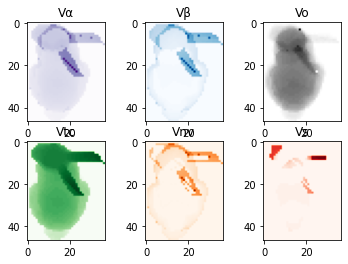

In [ ]:
# Step 4-1. 2D plots
print('Rendering tomographs..')

alpha_plot = createPlot( alpha_pixels_np, x0, y0, x1, y1)
beta_plot  = createPlot(  beta_pixels_np, x0, y0, x1, y1)
NV_plot    = createPlot(    NV_pixels_np, x0, y0, x1, y1)
Vo_plot    = createPlot(    Vo_pixels_np, x0, y0, x1, y1)
SS_plot    = createPlot(    SS_pixels_np, x0, y0, x1, y1)

plt.subplot(2,3,1);plt.title("Vα"); plt.imshow(alpha_plot, aspect='equal', cmap=plt.get_cmap('Purples'));
plt.subplot(2,3,2);plt.title("Vβ"); plt.imshow( beta_plot, aspect='equal', cmap=plt.get_cmap('Blues'));
plt.subplot(2,3,4);plt.title("Vtc"); plt.imshow(   TC_plot, aspect='equal', cmap=plt.get_cmap('Greens'));
plt.subplot(2,3,5);plt.title("Vnv"); plt.imshow(   NV_plot, aspect='equal', cmap=plt.get_cmap('Oranges'));
plt.subplot(2,3,3);plt.title("Vo");  plt.imshow(   Vo_plot, aspect='equal', cmap=plt.get_cmap('Greys'));
plt.subplot(2,3,6);plt.title("Vs");  plt.imshow(   SS_plot, aspect='equal', cmap=plt.get_cmap('Reds'));
plt.show()


# #4-2. Rendering (3D)

(Optional) 3D mesh rendering. Note that 3D rendering of Open3D package (o3d.visualization) is not supported by CoLab yet and Matplotlib was used instead.

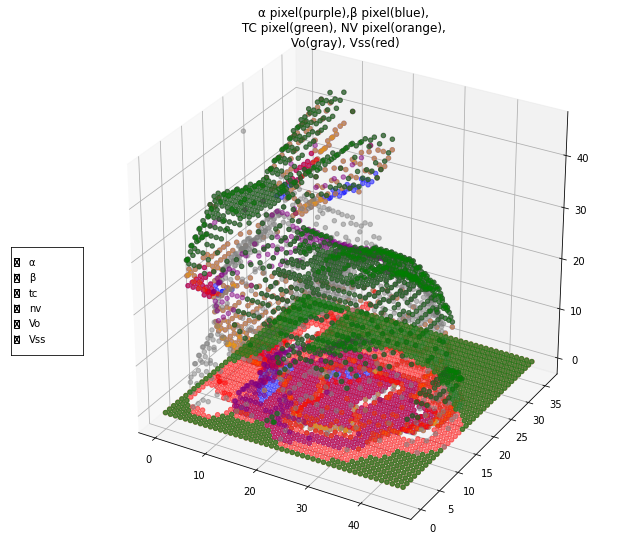

Finished.


In [ ]:
#step 4-2. 3D plots 

#o3d.visualization.draw_geometries([alpha_mesh_o3d+beta_mesh_o3d+NV_mesh_o3d])#view triangle mesh
#o3d.visualization.draw_geometries([alpha_pixels_o3d+beta_pixels_o3d+NV_pixels_o3d+TC_pixels_o3d])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') # Axe3D object
scatterA  = ax.scatter( alpha_pixels_np[:,0], alpha_pixels_np[:,1], alpha_pixels_np[:,2], alpha=0.5, color='purple')
scatterB  = ax.scatter(  beta_pixels_np[:,0],  beta_pixels_np[:,1],  beta_pixels_np[:,2], alpha=0.5, color='blue')
scatterTC = ax.scatter(    TC_pixels_np[:,0],    TC_pixels_np[:,1],    TC_pixels_np[:,2], alpha=0.5, color='green')
scatterNV = ax.scatter(    NV_pixels_np[:,0],    NV_pixels_np[:,1],    NV_pixels_np[:,2], alpha=0.5, color='orange')
scatterVo = ax.scatter(    Vo_pixels_np[:,0],    Vo_pixels_np[:,1],    Vo_pixels_np[:,2], alpha=0.5, color='gray')
scatterSS = ax.scatter(    SS_pixels_np[:,0],    SS_pixels_np[:,1],    SS_pixels_np[:,2], alpha=0.5, color='red')
plt.title("α pixel(purple),β pixel(blue),\n TC pixel(green), NV pixel(orange), \n Vo(gray), Vss(red)")

from matplotlib.widgets import CheckButtons
rax = plt.axes([0.05, 0.4, 0.1, 0.15])
lines = [scatterA, scatterB, scatterTC, scatterNV, scatterVo, scatterSS]
labels = ["α", "β", "tc", "nv", "Vo", "Vss"]
visibility = [line.get_visible() for line in lines]
check = CheckButtons(rax, labels, visibility)
def func(label):
 index = labels.index(label); lines[index].set_visible(not lines[index].get_visible()); plt.draw()
check.on_clicked(func) # Note: checkboxes do not work in Google Colab.
plt.show()

print('Finished.')
